# satCORPS composite Sketch #2 Subsetting

- Uses starepandas branch granular_democracy


In [1]:
import pystare
import starepandas
import geopandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import datetime

import regionmask
import xarray
from shapely.geometry import Polygon

In [2]:
import dask

In [3]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [4]:
from starepandas.io.granules import Granule

class satcorps_composite(Granule):

    def __init__(self, file_path, sidecar_path=None):
        super(satcorps_composite, self).__init__(file_path, sidecar_path)
        self.nom_res = ''
        self.companion_prefix = 'composite'
        
        self.source_nc = starepandas.io.s3.nc4_dataset_wrapper(self.file_path, 'r', format='NETCDF4')
        self.lat = None
        self.lon = None
        self.data = {}

    def read_data(self):
        if False:
            dataset_names = ['time' # "days since 1858-11-17T00:00:00.000"
                             ,'map_data/BT_10.8um']

            for dataset_name in dataset_names:
                self.data[dataset_name] = self.source_nc.select(dataset_name).get()
        
#        self.data['time'] = self.source_nc['time'][:].astype(numpy.double)
        self.data['BT_12_0um'] = self.source_nc.groups['map_data']['BT_12.0um'][:].astype(numpy.double)
        lat = self.source_nc.groups['map_data']['lat'][:].astype(numpy.double); nlat=len(lat)
        lon = self.source_nc.groups['map_data']['lon'][:].astype(numpy.double); nlon=len(lon)
        self.data['lats'] = numpy.ascontiguousarray(numpy.tile(lat,(nlon,1)).transpose())
        self.data['lons'] = numpy.tile(lon,(nlat,1))

            
starepandas.io.granules.granule_factory_library['composite']=satcorps_composite

starepandas.io.granules.granule_factory_library

{'MOD05|MYD05': starepandas.io.granules.modis.Mod05,
 'MOD09|MYD09': starepandas.io.granules.modis.Mod09,
 'VNP02DNB|VJ102DNB': starepandas.io.granules.viirsl2.VNP02DNB,
 'VNP03DNB|VJ103DNB': starepandas.io.granules.viirsl2.VNP03DNB,
 'VNP03MOD|VJ103MOD': starepandas.io.granules.viirsl2.VNP03MOD,
 'CLDMSKL2VIIRS': starepandas.io.granules.viirsl2.CLDMSKL2VIIRS,
 'SSMIS': starepandas.io.granules.ssmis.SSMIS,
 'ATMS': starepandas.io.granules.atms.ATMS,
 'composite': __main__.satcorps_composite}

!wget https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip

In [5]:
# Get some locales
if True:
    states = geopandas.read_file('tl_2019_us_state.zip')
    states = starepandas.STAREDataFrame(states)
    sids = states.make_sids(n_workers=50, resolution=10)
    states.set_sids(sids, inplace=True)
    trixels = states.make_trixels(n_workers=50, wrap_lon=False)
    states.set_trixels(trixels, inplace=True)
    states.split_antimeridian(inplace=True)

In [6]:
if True:
    # roi=states[states.NAME=='Hawaii']
    # roi=states[states.NAME=='California']
    conus = states[~states['NAME'].isin(['Alaska'
                                         ,'Hawaii'
                                         ,'United States Virgin Islands'
                                         ,'Commonwealth of the Northern Mariana Islands'
                                         ,'Guam'
                                         ,'American Samoa'
                                         ,'Puerto Rico'])]
    # roi = conus
    
    conus1 = starepandas.STAREDataFrame(conus.dissolve())
    conus1.set_sids(conus1.make_sids(resolution=7),inplace=True)
    conus1.set_trixels(conus1.make_trixels(),inplace=True)
    
    roi = starepandas.STAREDataFrame(sids=conus1.stare_dissolve(n_workers=50,aggfunc='first'))
    roi.set_trixels(roi.make_trixels(),inplace=True)
    

In [7]:
if False:
    roi.to_hdf('conus-roi.h5','stare_indexed')

In [8]:
starepandas.STAREDataFrame(conus1)

,geometry,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,sids,trixels
0,"MULTIPOLYGON (((-93.83568 29.59677, -93.83649 ...",3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"[3332663724254167043, 3071454945866678276, 307...","MULTIPOLYGON (((-90.00000 35.26439, -101.10559..."


In [9]:
# Get some locales
if False:
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world.sort_values(by='name', inplace=True)
    world = starepandas.STAREDataFrame(world)
    
    if False:
        world.plot(trixels=False)

In [10]:
if False:
    roi = world[world.name=='United States of America']
    # roi = world[world.name=='Bahamas']
    # roi = world[world.name=='Vanuatu']
    # roi = world[world.name=='Iceland']

In [11]:
if False:
    roi.set_sids(roi.make_sids(resolution=7),inplace=True)
    roi.set_trixels(roi.make_trixels(),inplace=True)

In [12]:
roi

,sids,trixels
0,3037748317405577223,"POLYGON ((-68.24597 44.62110, -67.86712 43.678..."
1,3037959423638110214,"POLYGON ((-69.04200 46.50281, -68.24597 44.621..."
2,3038100161126465542,"POLYGON ((-67.22055 45.86076, -68.24597 44.621..."
3,3038944586056597511,"POLYGON ((-69.04200 46.50281, -68.52670 47.128..."
4,3038979770428686343,"POLYGON ((-67.99917 47.75118, -68.94132 48.068..."
...,...,...
297,3450073973914599431,"POLYGON ((-108.69725 32.31924, -109.15351 31.3..."
298,3450144342658777095,"POLYGON ((-109.15351 31.30649, -108.34728 30.4..."
299,3450214711402954759,"POLYGON ((-108.69725 32.31924, -109.97485 32.1..."
300,3450249895775043591,"POLYGON ((-111.24716 31.94014, -110.41646 31.1..."


In [13]:
type(roi)

starepandas.staredataframe.STAREDataFrame

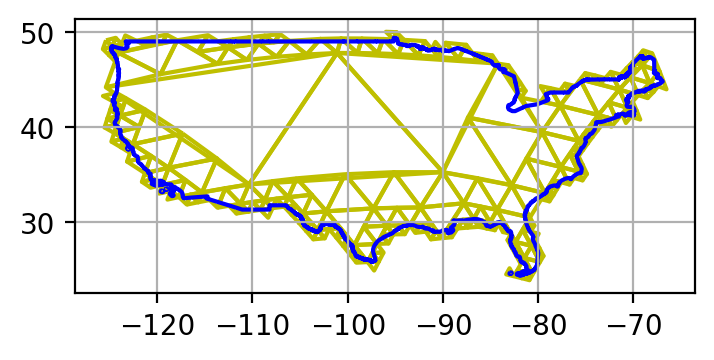

In [14]:
#
if True:
    fig, ax = plt.subplots(figsize=(4,4), dpi=200)
    ax.grid(True)


    roi.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1)
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

    del fig,ax

In [15]:
start0 = datetime.datetime.now()

In [16]:
# Load the granule
if True:
    granule_name = 'ignored/satCORPS/composite_20220420_2019.182.0230.nc'
    composite = starepandas.read_granule(granule_name, sidecar=True, latlon=False, sidecar_path='ignored/satCORPS/satCORPS_composite_stare.nc')
    print(datetime.datetime.now() - start0)

saving:  BT_12_0um
saving:  lats
saving:  lons
0:00:15.167897


In [17]:
# a = composite.stare_intersects(roi['sids'].iloc[0],n_workers=50)
a = composite.stare_intersects(roi['sids'].iloc[:].to_numpy(),n_workers=50)
print(datetime.datetime.now() - start0)

0:00:37.811868


In [18]:
composite_subset = composite[a]

In [19]:
print(datetime.datetime.now() - start0)

0:00:37.910530


0:00:38.141261


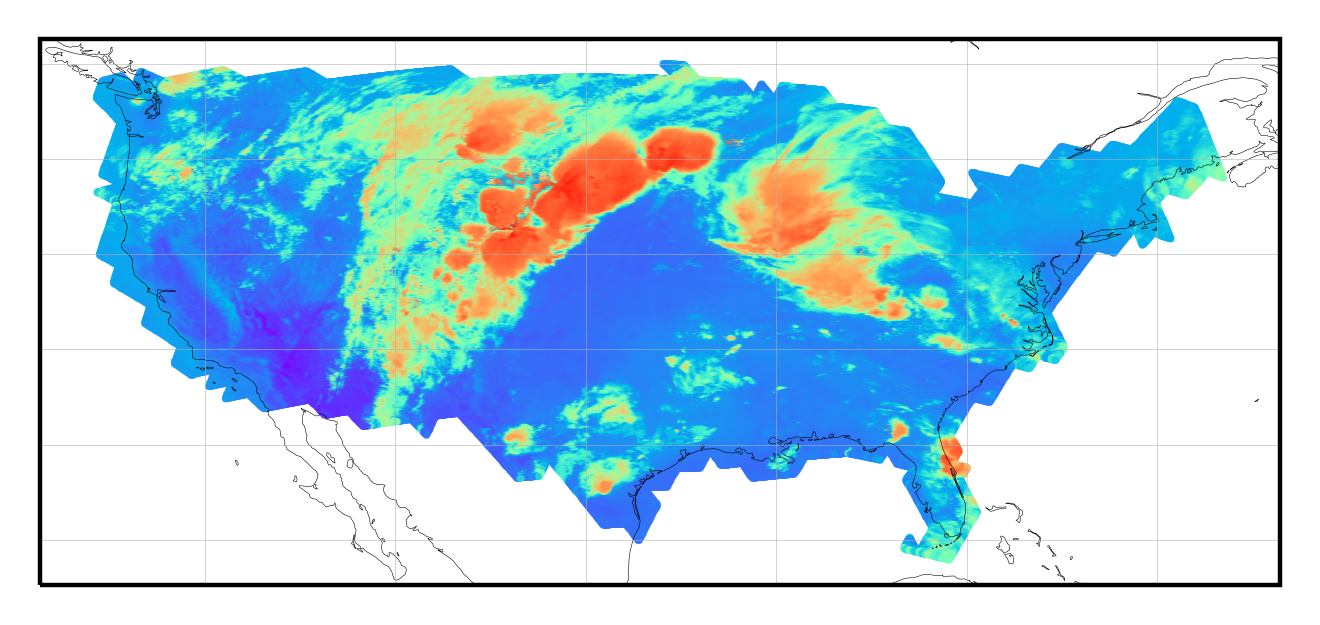

In [20]:
fig, ax = plt.subplots(figsize=(4,4), dpi=400
                       ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)
# ax.grid(True)
if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.05
    marker_alpha=0.5
    
marker='s'

# jdf1.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# jdf1.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(composite_subset['lons']
           ,composite_subset['lats']
           ,s=marker_size
           ,c=composite_subset['BT_12_0um']
           ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
           ,cmap='rainbow_r'
           ,marker=marker
           ,rasterized=True
           ,transform=ccrs.PlateCarree()
                               )
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

# roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
# conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print(datetime.datetime.now() - start0)

In [21]:
print(datetime.datetime.now() - start0)

0:00:51.504154


In [22]:
type(composite)

starepandas.staredataframe.STAREDataFrame

In [23]:
composite_sorted = composite.sort_values('sids')
composite_sorted

,sids,BT_12_0um,lats,lons
59134501,97292061228,284.619995,-29.986486,9.770271
59161141,209793238284,284.910004,-30.040541,9.770271
59161142,259841081932,284.519989,-30.040541,9.797298
59134502,385717242988,284.220001,-29.986486,9.797298
59147822,418474897452,284.320007,-30.013514,9.797298
...,...,...,...,...
32494822,4611685808816186732,293.729980,24.067566,18.445948
32494821,4611685835015846572,293.690002,24.067566,18.418921
32481501,4611685903886623372,293.679993,24.094593,18.418921
32468182,4611685955892864652,293.729980,24.121620,18.445948


In [24]:
composite_sorted['sids'].iloc[0]

97292061228

In [25]:
composite_sorted.to_hdf('composite.h5','stare_sorted',format='fixed',data_columns=['sids','BT_12_0um','lats','lons'])

In [26]:
# !rm composite.h5

In [27]:
# !open composite.h5

In [28]:
import pandas
df = pandas.read_hdf('composite.h5',key='stare_sorted',mode='r',start=32481502,stop=32494822)

In [29]:
df['sids']

73653905    2124908873140814317
73640585    2124908887755067213
73640586    2124908917337691373
73653907    2124908929144547885
73640588    2124908990139612141
                   ...         
73201269    2125535115911769037
73187960    2125535254893082349
73174637    2125535345721697293
73174638    2125535352778294317
73201275    2125535494082185037
Name: sids, Length: 13320, dtype: int64

In [30]:
type(df)

pandas.core.frame.DataFrame

In [31]:
import pandas as pd
import numpy as np
index = pd.date_range("1/1/2000", periods=8)
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
d = pd.DataFrame(np.random.randn(8, 3), index=index, columns=["A", "B", "C"])

In [32]:
d

,A,B,C
2000-01-01,0.559999,-1.804426,-0.652621
2000-01-02,-0.825848,1.559001,1.181565
2000-01-03,-0.032923,-0.945178,1.004001
2000-01-04,0.249205,-0.521737,-2.118385
2000-01-05,-1.102109,0.791234,0.854778
2000-01-06,0.275878,-0.601609,-0.494706
2000-01-07,-1.307779,1.308443,-0.306342
2000-01-08,-0.971408,0.272057,-1.043528


In [33]:
d.to_hdf('d.h5','data',format='fixed',data_columns=['A','B','C'])

In [34]:
# !open d.h5

In [35]:
d1=d.sort_values('A')

In [36]:
d1.to_hdf('d1.h5','data',format='fixed',data_columns=['A','B','C'])

In [37]:
d1

,A,B,C
2000-01-07,-1.307779,1.308443,-0.306342
2000-01-05,-1.102109,0.791234,0.854778
2000-01-08,-0.971408,0.272057,-1.043528
2000-01-02,-0.825848,1.559001,1.181565
2000-01-03,-0.032923,-0.945178,1.004001
2000-01-04,0.249205,-0.521737,-2.118385
2000-01-06,0.275878,-0.601609,-0.494706
2000-01-01,0.559999,-1.804426,-0.652621


In [38]:
# !open d1.h5

In [39]:
def hex16(i):
    return "0x%016x"%i

In [40]:
level = 4
level_increment = pystare.spatial_increment_from_level(level)

nsids_at_level = (8 * (4**level))
sids_at_level = numpy.zeros([nsids_at_level],dtype=numpy.int64)

k = 0
# Plot each increment (overlay on common axes)
for siv_idx, siv in enumerate(range(0, nsids_at_level*level_increment, level_increment)):
    siv = siv + level # Set the level
    sids_at_level[k] = siv
    # print(k,siv,hex16(siv))
    k += 1

In [41]:
stare_row_offsets = numpy.zeros([nsids_at_level],dtype=numpy.int64)

In [42]:
for i in range(10):
    print(composite_sorted['sids'][i+1]-composite_sorted['sids'][i],i)

-25952 0
2176 1
-434848 2
15552 3
2176 4
-8096 5
-60798432 6
32672 7
1600 8
9088 9


In [43]:
def binary_find(s,a):
    n=len(a)
    c=int(n/2)
    d=int(n/2)
    while d>0:
        # print(s,c,d,a.iloc[c])
        d = int(d/2)
        if s > a.iloc[c]:
            c += d
        elif s < a.iloc[c]:
            c -= d
        else:
            d=0
    return c-1

In [44]:
class chunk_lite:
    def __init__(self,start,stop):
        self.start = start
        self.stop  = stop
        return
    
pods_lite = {}
pods_lite_level = level

In [45]:
stare_row_offsets[0] = 0
stare_bounds = {}

for k in range(1,nsids_at_level):
    stare_row_offsets[k] = binary_find(sids_at_level[k],composite_sorted['sids'])
    
for k in range(0,nsids_at_level):
    start = binary_find(sids_at_level[k],composite_sorted['sids'])
    stop  = binary_find(pystare.spatial_terminator(sids_at_level[k]),composite_sorted['sids'])
    if start != stop:
        pods_lite[sids_at_level[k]] = chunk_lite(start,stop)

if False:
    for l in range(nsids_at_level):
        print(l,hex16(sids_at_level[l]),hex16(sids_at_level[l]),hex16(composite_sorted['sids'].iloc[stare_row_offsets[l]]),stare_row_offsets[l])

    for k in pods_lite.keys():
        print(hex16(k),pods_lite[k].start,pods_lite[k].stop)
    

In [46]:
keys = list(pods_lite.keys())
print('len keys: ',len(keys))

len keys:  2048


In [47]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [48]:
# take the intersection, get the level, coerce to it, then uniquify, then loop, load, and concat.
def read_hdf(filename,sids,pods_lite):
    resolution = int(pystare.spatial_resolution(list(pods_lite.keys())[0]))
    
    idx = numpy.unique(
        pystare.spatial_clear_to_resolution(
            pystare.spatial_coerce_resolution(pystare.expand_intervals(sids,resolution),resolution)))
                                              
    # print(idx)
    dfs = []
    for s in idx:
        chunk = pods_lite[s]
        df = pandas.read_hdf('composite.h5',start=chunk.start+2,stop=chunk.stop)
        dfs.append(df)
        
    return pandas.concat(dfs)

0:00:05.631275
time:  0:00:05.788585


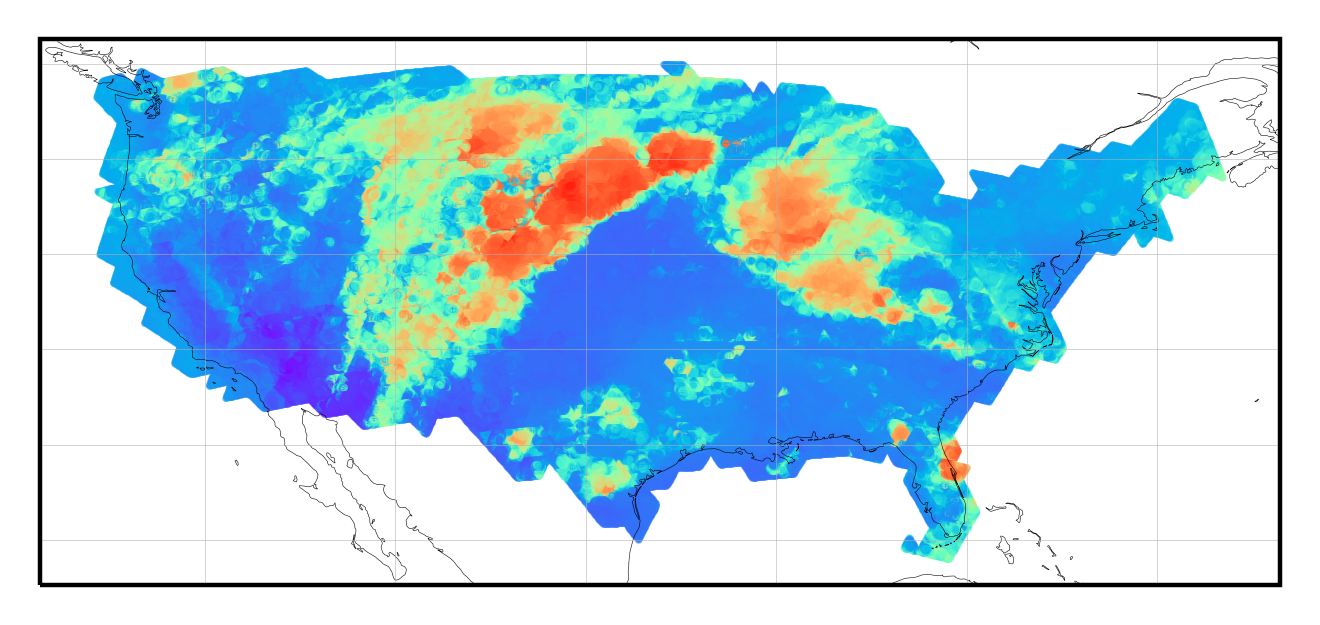

In [49]:
start0 = datetime.datetime.now()

# i = 90
# chunk = pods_lite[keys[i]]
# df = pandas.read_hdf('composite.h5',start=chunk.start+2,stop=chunk.stop)

# bdf = states[states.NAME=='Hawaii']
# b = states[states.NAME=='Hawaii']['sids'].iloc[0]

b = roi['sids'].iloc[:].to_numpy()

df = starepandas.STAREDataFrame(read_hdf('composite.h5',b,pods_lite)).reset_index()
c = df.stare_intersects(b,n_workers=50)
df = df[c]

print(datetime.datetime.now() - start0)

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

# Doesn't work for 1-D data
# ax.contourf(df['lons'],df['lats'],df['BT_12_0um']
#            ,cmap='nipy_spectral'
#            ,cmap='rainbow'
#            ,transform=ccrs.PlateCarree()
#        )
if True:
    ax.scatter(df['lons'],df['lats']
                ,s=marker_size
                ,c=df['BT_12_0um']
                ,alpha=marker_alpha
    #            ,cmap='nipy_spectral'
                ,cmap='rainbow_r'
                ,marker=marker
                ,rasterized=True
                ,transform=ccrs.PlateCarree()
                )
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print('time: ',datetime.datetime.now()-start0)

In [50]:
print(datetime.datetime.now() - start0)

0:00:15.200957


<AxesSubplot:>

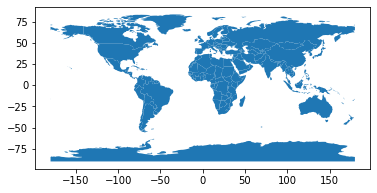

In [51]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot()

In [52]:
conus_boundary = world[world['name'] == 'United States of America'].clip(
    Polygon([(-125,24.5),(-66,24.5),(-66,49.5),(-125,49.5)])
).boundary


<AxesSubplot:>

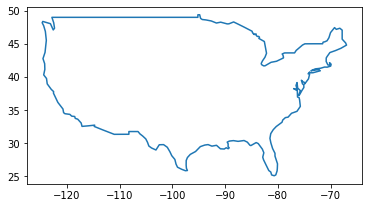

In [53]:
conus_boundary.plot()

In [54]:
start0 = datetime.datetime.now()

In [55]:
with xarray.open_dataset('ignored/satCORPS/composite_20220420_2019.182.0230.nc'
                         ,engine='netcdf4'
                         ,group='map_data'
                         ,decode_times=False
                        ) as file_nc:
     composite_file_nc = file_nc

In [56]:
print(datetime.datetime.now() - start0)

0:00:00.067759


In [57]:
lons = composite_file_nc.lon[:]
lats = composite_file_nc.lat[:]
lon, lat = numpy.meshgrid(lons, lats)

In [58]:
my_regions = regionmask.Regions(conus_boundary)
mask = my_regions.mask(lon,lat)

/Users/mrilee/opt/anaconda3/envs/pystare-dev-1/lib/python3.10/site-packages/regionmask/core/regions.py:108: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  regions[n] = _OneRegion(n, names[n], abbrevs[n], outlines[n])


In [59]:
print(datetime.datetime.now() - start0)

0:00:29.612439


In [60]:
start0 = datetime.datetime.now()

In [61]:
with xarray.open_dataset('ignored/satCORPS/composite_20220420_2019.182.0230.nc'
                         ,engine='netcdf4'
                         ,group='map_data'
                         ,decode_times=False
                        ) as file_nc:
     composite_file_nc = file_nc
print(datetime.datetime.now() - start0)

0:00:00.022558


In [62]:
BT12um_masked=composite_file_nc['BT_12.0um'].where(~numpy.isnan(mask.data))

In [63]:
print(datetime.datetime.now() - start0)

0:00:01.603660


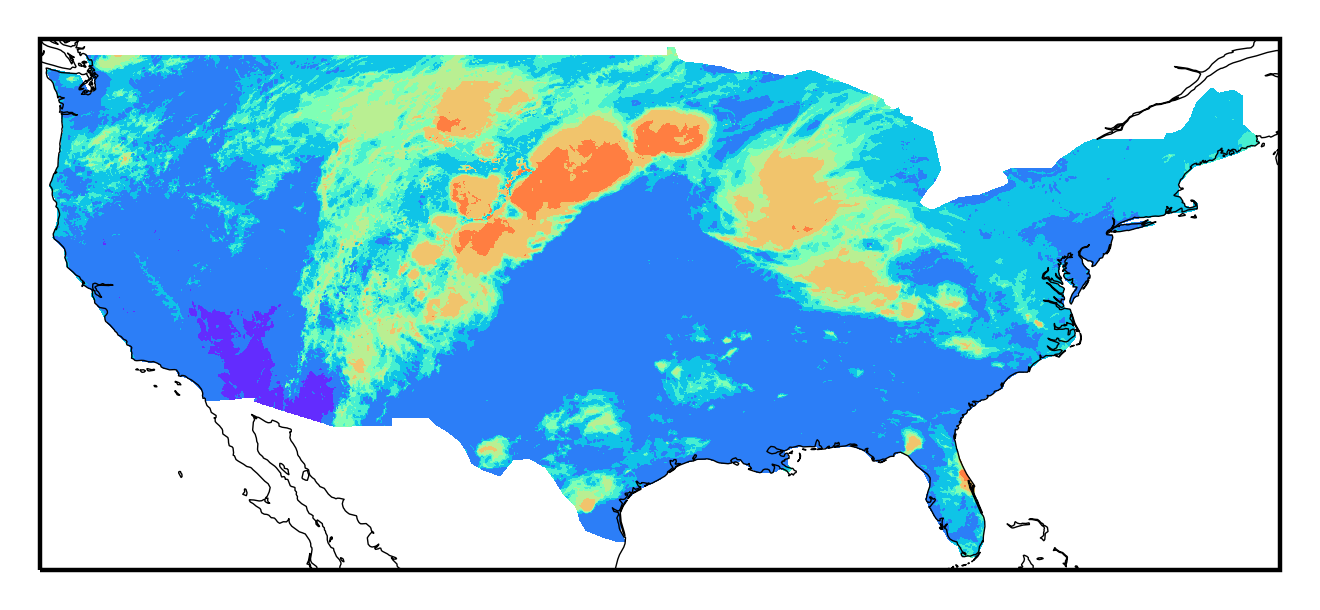

0:00:15.573870


In [64]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
# ax.set_global()
ax.set_xlim(-125,-66)
ax.set_ylim(24.5,49.75)

# BT12um_masked.plot(ax=ax,transform=ccrs.PlateCarree())
ax.contourf(lon,lat,BT12um_masked,transform=ccrs.PlateCarree(),cmap='rainbow_r')

ax.coastlines(linewidth=0.25)

plt.show()
del fig,ax

print(datetime.datetime.now() - start0)

In [65]:
print(datetime.datetime.now() - start0)

0:00:15.580290


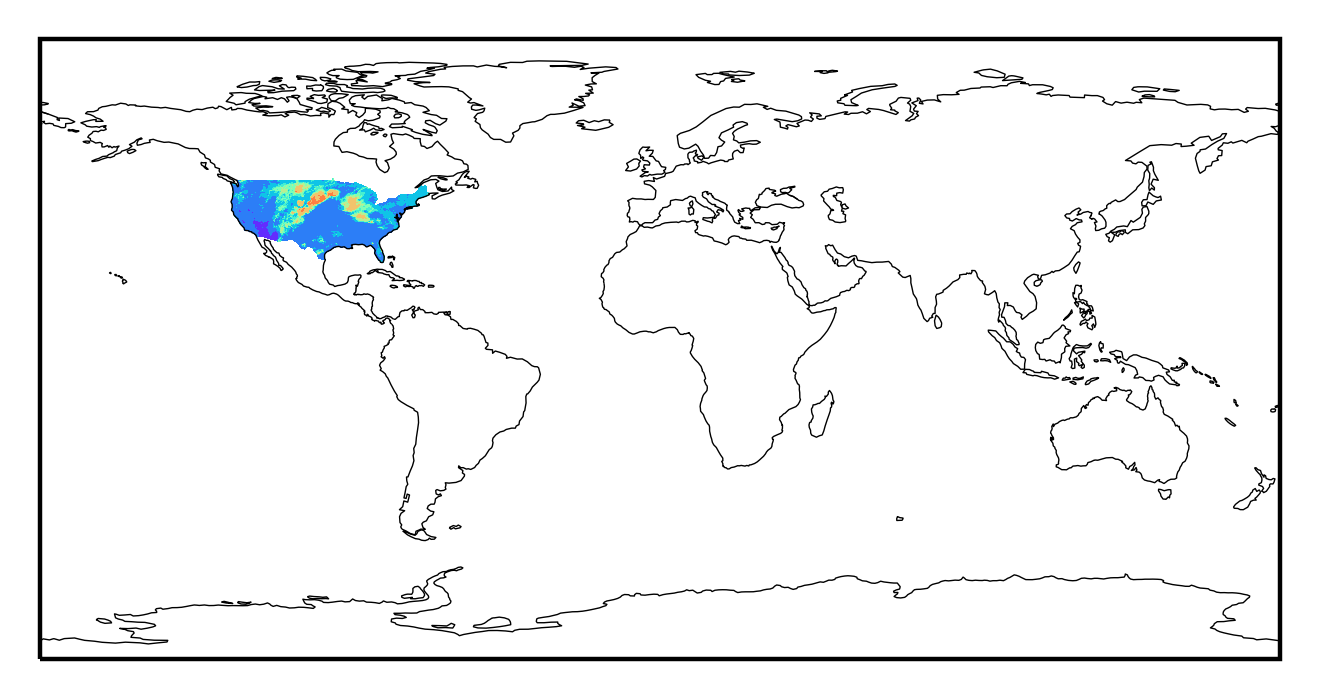

0:00:31.113985


In [66]:
fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
# ax.set_global()

# BT12um_masked.plot(ax=ax,transform=ccrs.PlateCarree())
ax.contourf(lon,lat,BT12um_masked,transform=ccrs.PlateCarree(),cmap='rainbow_r')

ax.coastlines(linewidth=0.25)

plt.show()
del fig,ax

print(datetime.datetime.now() - start0)

In [67]:
print(datetime.datetime.now() - start0)

0:00:31.120683


In [ ]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(lon,lat
            ,s=marker_size
            ,c=BT12um_masked.data
            ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
            ,cmap='rainbow_r'
            ,marker=marker
            ,rasterized=True
            ,transform=ccrs.PlateCarree()
            )
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print('time: ',datetime.datetime.now()-start0)

time:  0:00:11.632131
